In [1]:
!/opt/conda/bin/conda install -y --quiet -c plotly plotly

Solving environment: ...working... 
The environment is inconsistent, please check the package plan carefully
The following packages are causing the inconsistency:

  - defaults/linux-64::anaconda==2019.07=py37_0
  - defaults/linux-64::numba==0.44.1=py37h962f231_0
done

## Package Plan ##

  environment location: /opt/conda

  added / updated specs:
    - plotly


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    plotly-4.3.0               |             py_0         4.1 MB  plotly
    ------------------------------------------------------------
                                           Total:         4.1 MB

The following NEW packages will be INSTALLED:

  _anaconda_depends  pkgs/main/linux-64::_anaconda_depends-2019.03-py37_0
  plotly             plotly/noarch::plotly-4.3.0-py_0
  retrying           pkgs/main/linux-64::retrying-1.3.3-py37_2
  tbb                pkgs/main/linux-64::tbb-201

In [2]:
%matplotlib inline
import pandas as pd
import numpy as np
import glob
from sklearn.preprocessing import MinMaxScaler
from sklearn.manifold import TSNE
import matplotlib.pylab as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from collections import defaultdict

from statsmodels.graphics.tsaplots import plot_acf

# Description

This notebook demonstrates how to play with jpxlab.

# Preparation

**(caution)** This requires about 55GB of local disk space

## Download files from FTP server (all files for 2019 September)

```
$ cd tools/fetcher
$ ./fetch.sh '201909??'
```

## Convert raw FLEX stream into dataframe

```
$ python cli.py convert /opt/jpxlab/downloads/*.zip
```

## Resample ticks to hourly candles

```
$ python cli.py resample -f 1H /opt/jpxlab/downloads/*.h5
```

# Security List

In [3]:
tbl = pd.read_excel("https://www.jpx.co.jp/english/markets/statistics-equities/misc/tvdivq0000001vg2-att/data_e.xls")

def lookup_security_info(code):
    if type(code) is not int:
        code = int(code[-4:])
    return tbl[tbl["Local Code"] == code]

def lookup_top_100():
    return tbl[
        (tbl["Size (New Index Series)"] == 'TOPIX Large70') | 
        (tbl["Size (New Index Series)"] == 'TOPIX Core30')]

# Loading data - Multiple Files (only top 100 securites)

In [4]:
buf = defaultdict(list)

keys = lookup_top_100()["Local Code"].values

for file in glob.glob("/opt/jpxlab/downloads/StandardEquities_201909??_1H.h5"):
    with pd.HDFStore(file, "r") as h5:
        for k in keys:
            k = "t{}".format(k)
            buf[k].append(h5[k])
top_100 = dict(list(map(
    lambda k: (k, pd.concat(buf[k]).sort_index()),
    buf.keys()
)))

In [5]:
top_100["t7203"].head()

,open,high,low,close,volume,amount
time,,,,,,
2019-09-02 09:00:00,6967.0,6973.0,6940.0,6949.0,1071400.0,7.457961e+09
2019-09-02 10:00:00,6949.0,6966.0,6945.0,6965.0,464000.0,3.229453e+09
2019-09-02 11:00:00,6965.0,6971.0,6963.0,6963.0,190900.0,1.329941e+09
2019-09-02 12:00:00,6949.0,6966.0,6946.0,6966.0,255000.0,1.773506e+09
2019-09-02 13:00:00,6966.0,6978.0,6964.0,6970.0,311900.0,2.174106e+09


## Loading data - Multiple Files (everything and filter out top 100 well traded securities)

In [6]:
buf = defaultdict(list)

for file in glob.glob("/opt/jpxlab/downloads/StandardEquities_201909??_1H.h5"):
    with pd.HDFStore(file, "r") as h5:
        for k in h5.keys():
            k = k[1:]
            buf[k].append(h5[k])
            
all_stocks = dict(list(map(
    lambda k: (k, pd.concat(buf[k]).sort_index()),
    buf.keys()
)))

In [7]:
total_amounts = dict(list(map(
    lambda k: (k, all_stocks[k].amount.sum()),
        all_stocks.keys()
)))

In [8]:
top_100_traded = pd.Series(total_amounts).sort_values().iloc[-100:].index
top_100_traded

Index(['t2432', 't6902', 't4901', 't6178', 't6502', 't9201', 't9684', 't6723',
       't5108', 't6971', 't4543', 't9020', 't9022', 't6702', 't4689', 't6762',
       't7741', 't3382', 't7269', 't6506', 't4452', 't6976', 't6594', 't3436',
       't8766', 't4755', 't6367', 't4063', 't6501', 't4661', 't4911', 't6273',
       't6857', 't4568', 't3656', 't9432', 't3668', 't2413', 't6981', 't8316',
       't3092', 't6954', 't4502', 't6861', 't7202', 't1357', 't4528', 't8035',
       't5802', 't2802', 't9502', 't8795', 't7270', 't9531', 't6758', 't6098',
       't8601', 't9503', 't3407', 't7203', 't9983', 't3402', 't8267', 't5411',
       't7261', 't6326', 't8308', 't8002', 't9064', 't5401', 't7974', 't1605',
       't4188', 't2503', 't6752', 't6503', 't9984', 't8750', 't1928', 't5020',
       't8802', 't8053', 't8604', 't7201', 't7751', 't4503', 't8591', 't8031',
       't1570', 't8001', 't6301', 't8801', 't9437', 't2914', 't7267', 't9434',
       't9433', 't8058', 't8411', 't8306'],
      dt

## Extract `amount` column

In [9]:
amounts = pd.concat(
    [
        v.amount.to_frame(k)
        for k, v in top_100.items()
    ],
    axis=1
)

In [10]:
amounts.head()

,t1605,t1878,t1925,t1928,t2502,t2503,t2802,t2914,t3382,t3402,...,t9433,t9434,t9437,t9502,t9503,t9531,t9735,t9843,t9983,t9984
time,,,,,,,,,,,,,,,,,,,,,
2019-09-02 09:00:00,9.808424e+09,840084000.0,452915700.0,6.708278e+09,899833200.0,8.433489e+09,4.341351e+09,2.121325e+10,1.793389e+09,6.399232e+09,...,2.117106e+10,1.524679e+10,1.743698e+10,3.699513e+09,3.685407e+09,4.585515e+09,824111900.0,594400000.0,7.985295e+09,1.817376e+10
2019-09-02 10:00:00,3.223250e+09,299090500.0,262648700.0,3.583874e+09,668095000.0,2.748273e+09,3.657578e+09,7.931520e+09,4.157265e+08,2.612251e+09,...,6.225022e+09,7.488206e+09,8.359501e+09,1.488484e+09,1.169696e+09,3.506674e+09,244672300.0,209313500.0,2.069470e+09,6.389082e+09
2019-09-02 11:00:00,1.981906e+09,137435000.0,95190500.0,1.969151e+09,168622000.0,1.201199e+09,7.588170e+08,5.276894e+09,1.384356e+08,1.190372e+09,...,2.561301e+09,2.776468e+09,2.595377e+09,6.311245e+08,6.154085e+08,4.514800e+08,101883100.0,103815500.0,3.145008e+09,1.901156e+09
2019-09-02 12:00:00,3.491510e+09,248292000.0,214883800.0,2.742885e+09,322958600.0,2.146128e+09,1.288966e+09,9.238498e+09,2.783417e+08,1.631510e+09,...,5.761988e+09,4.673812e+09,5.206800e+09,1.234480e+09,1.184154e+09,1.117544e+09,167479100.0,230659500.0,1.533181e+09,2.150855e+09
2019-09-02 13:00:00,2.215488e+09,164644000.0,312223200.0,3.607746e+09,336469500.0,2.372885e+09,1.461940e+09,7.092724e+09,2.290313e+08,1.783855e+09,...,6.667778e+09,5.712989e+09,6.959141e+09,1.596428e+09,1.486424e+09,1.205808e+09,231398000.0,232511000.0,3.749209e+09,2.239468e+09


# group by sector

In [11]:
sector_tbl = lookup_top_100()[["Local Code", "17 Sector(name)"]].set_index("Local Code")
sectors = sector_tbl["17 Sector(name)"].unique()
amounts_by_sector = pd.concat(
    [
        amounts[list(map(
            lambda x: "t{}".format(x),  # add the heading 't'
            sector_tbl[sector_tbl["17 Sector(name)"] == sector].index.values
        ))].sum(axis=1).to_frame(sector)
        for sector in sectors
    ],
    axis=1)

In [12]:
amounts_by_sector.head()

,ENERGY RESOURCES,CONSTRUCTION & MATERIALS,FOODS,RETAIL TRADE,RAW MATERIALS & CHEMICALS,PHARMACEUTICAL,ELECTRIC APPLIANCES & PRECISION INSTRUMENTS,"IT & SERVICES, OTHERS",AUTOMOBILES & TRANSPORTATION EQUIPMENT,STEEL & NONFERROUS METALS,MACHINERY,COMMERCIAL & WHOLESALE TRADE,BANKS,FINANCIALS （EX BANKS）,REAL ESTATE,TRANSPORTATION & LOGISTICS,ELECTRIC POWER & GAS
time,,,,,,,,,,,,,,,,,
2019-09-02 09:00:00,2.475608e+10,8.001277e+09,3.488792e+10,1.798500e+10,2.772167e+10,4.164246e+10,7.584578e+10,1.040590e+11,6.679652e+10,1.821654e+10,2.670665e+10,6.743694e+10,8.214276e+10,5.787256e+10,2.492443e+10,5.794133e+09,1.197044e+10
2019-09-02 10:00:00,8.653445e+09,4.145614e+09,1.500547e+10,5.988866e+09,9.553992e+09,2.329515e+10,2.656429e+10,3.765217e+10,2.362601e+10,6.177064e+09,1.052347e+10,3.234839e+10,2.999630e+10,2.337085e+10,1.038734e+10,1.856882e+09,6.164854e+09
2019-09-02 11:00:00,4.900429e+09,2.201776e+09,7.405532e+09,5.017928e+09,4.329191e+09,7.771183e+09,9.336824e+09,1.338877e+10,1.092257e+10,2.148723e+09,3.403724e+09,1.179291e+10,1.230449e+10,9.305202e+09,4.277269e+09,8.848896e+08,1.698013e+09
2019-09-02 12:00:00,6.930666e+09,3.206061e+09,1.299655e+10,3.638696e+09,7.711131e+09,1.446005e+10,1.571751e+10,2.456445e+10,1.778794e+10,6.757986e+09,7.007147e+09,2.173018e+10,2.134328e+10,1.871803e+10,8.998949e+09,1.482719e+09,3.536178e+09
2019-09-02 13:00:00,6.076119e+09,4.084613e+09,1.126402e+10,7.162395e+09,1.029951e+10,1.383369e+10,2.199737e+10,2.948903e+10,2.196510e+10,1.261798e+10,9.461780e+09,2.551714e+10,2.318585e+10,2.037310e+10,8.863353e+09,1.597979e+09,4.288658e+09


## Resample daily

In [13]:
amounts_by_sector = amounts_by_sector.resample("D").sum()

## Viaualize

/opt/conda/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning:

Glyph 65288 missing from current font.

/opt/conda/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning:

Glyph 65289 missing from current font.

/opt/conda/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:180: RuntimeWarning:

Glyph 65288 missing from current font.

/opt/conda/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:180: RuntimeWarning:

Glyph 65289 missing from current font.



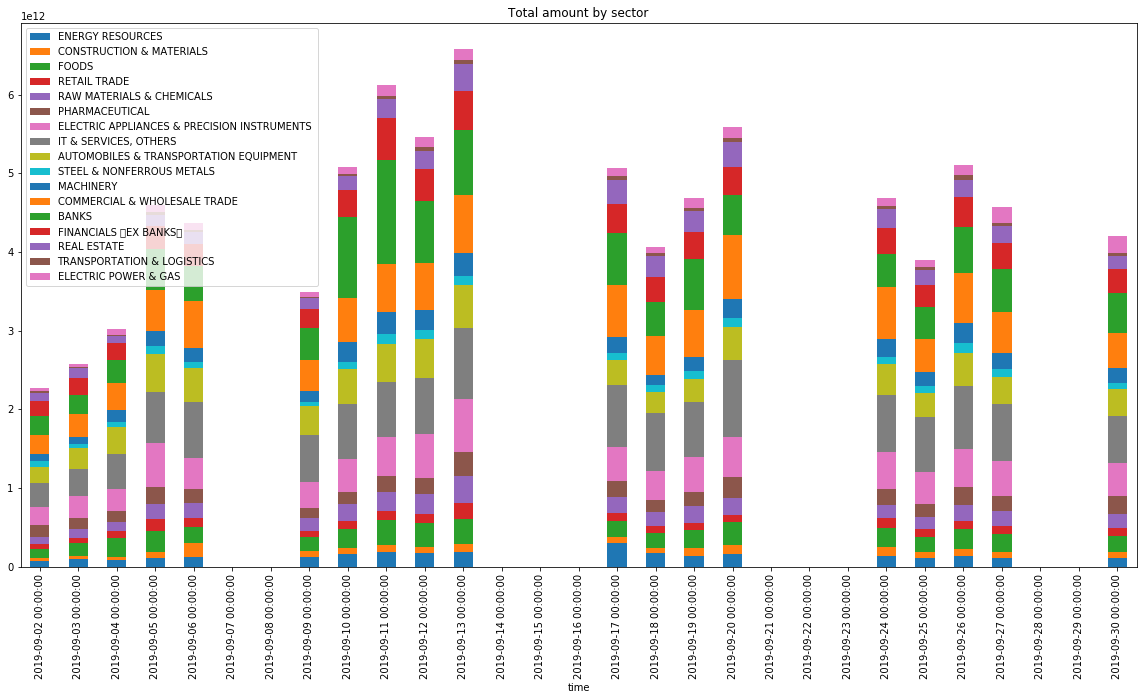

In [14]:
amounts_by_sector.plot(
    kind="bar", stacked=True, figsize=(20, 10),
    title="Total amount by sector"
)

## Visualize - Relative transition from the origin

Text(0.5, 1.0, 'Relative transition of traded amounts')

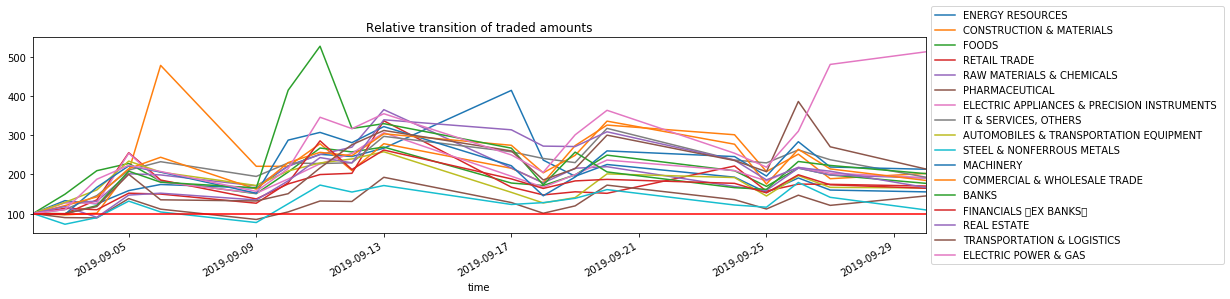

In [15]:
# offset by the starting point
offset_amounts_by_sector = amounts_by_sector[
    ~(amounts_by_sector==0).all(axis=1)  #  strip rows with zeros (weekends)
].subtract(
    amounts_by_sector.iloc[0], axis=1 # normalize to the starting point
)

# normalize by the starting point and shift to +100
ax = offset_amounts_by_sector.divide(
    amounts_by_sector.iloc[0], axis=1
).mul(100).add(100).plot(figsize=(16, 4))

ax.axhline(y=100, c="r")  # horizontal line at center

ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.title("Relative transition of traded amounts")

# Autocorrelation

Autocorrelation is known as correlation of time-series with its delayed copy. It's one of the easiest ways to see the predictability of the sequence.

Let's see how the autocorrelation of Toyota's stock price looks like.

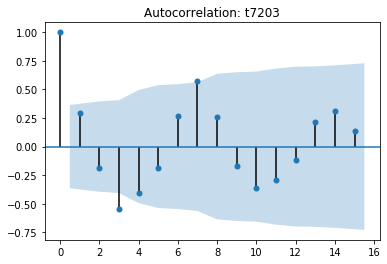

In [16]:
toyota = "t7203"
_ = plot_acf(
    amounts[toyota].resample("D").sum().reset_index()[toyota],
    title="Autocorrelation: {}".format(toyota))

The blue cloud shows the area of confidence interval, but as you can see, the correlation is not obvious in this case.

Then, Let's lookup the high self correlation stock and visualize it.

In [17]:
buf = []
for c in amounts.columns:
    buf.append((c, amounts[c].resample("D").sum().reset_index()[c].autocorr()))
high_correlation = pd.DataFrame.from_records(buf, columns=["symbol", "autocorr"]).set_index('symbol').idxmax().values[0]

In [18]:
lookup_security_info(high_correlation)

,Effective Date,Local Code,Name (English),Section/Products,33 Sector(Code),33 Sector(name),17 Sector(Code),17 Sector(name),Size Code (New Index Series),Size (New Index Series)
2833,20191031,7270,SUBARU CORPORATION,First Section (Domestic),3700,Transportation Equipment,6,AUTOMOBILES & TRANSPORTATION EQUIPMENT,2,TOPIX Large70


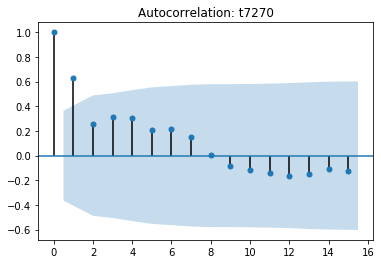

In [19]:
_ = plot_acf(
    amounts[high_correlation].resample("D").sum().reset_index()[high_correlation],
    title="Autocorrelation: {}".format(high_correlation))

The actual volume looks like this

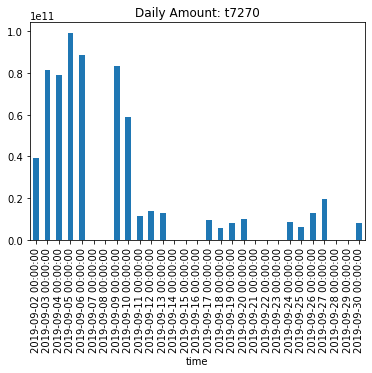

In [20]:
amounts[high_correlation].resample("D").sum().plot(kind="bar", title="Daily Amount: {}".format(high_correlation))